# Introduction

This notebook walks through creating a synthetic version of the `checkout` dataframe from Data Camp's "A/B Testing in Python" tutorial. (This is a case of translating concepts that I know in an academic context and in R into an industry context and Python.)

## Outline

This notebook is organized as a narrative tutorial. It has the following structure:

- Introduction
- Inital Description of Features
- Synthetic Independent Variables
- Synthetic Conditional Variables

# Initial Description of the Features


The goal of the following tutorial is to create a synthetic version of Data Camp's "checkout" data frame.

Before I start coding, it is worth identifying the data set features and giving some initial thought to the data generating process (DGP), dependencies, and any other considerations that might influence the implementation. 

At this point, I have only seen the summary data in the first few segments of the tutorial, so I'll start by making some assumptions about values and the data-generating process. I can go back and refine as needed.

### Features:

User_id: 

9000 unique integers.

We assume that this is independent of the other features and does not encode any other information. 

Thus, I can produce it by replicating the row numbers or with a simple 1:9000 call.

checkout_page: 

9000 objects

We can quickly discover that `checkout_page` is a categorical variable that takes the values of A, B, or C. It codes which landing page the shopper ended up on. Checkout_page is the experiment condition. 

I'll start the initial page assignment probability at 1/3 each and then iterate as I learn more about the data I am trying to simulate.

order_value: 

7605 floats.

Order value is a numeric vector of purchase values. At a minimum, we want this value to be conditional on the checkout page value. If we wanted a more complex DGP, we could consider a few paths: 
One option would be to generate the values as a function of a regression model: `Y_i = B1x1 + ...BnXn + e`

Alternatively, we could generate values as draws from a Bayesian distribution with however many priors we wanted.

However, without a compelling reason to make the distribution more complex, the simplest way to create the value is to model it via an assumed DGP and the checkout page.

Here, I will operationalize this based on the assumption that checkout rows are independently and identically distributed (i.i.d.) normal variables. I'll assume that the intervention—which checkout page the visitor lands on—shifts the mean and standard deviation of purchases. 
I am also assuming that condition "B" is the baseline.

- checkout_value | page = A ~ N(M + A_effect, sd)
- checkout_value | page = B ~N(M, sd)
- checkout_value | page = C ~ N(M + C_effect, sd)

With the data in front of me in the terminal, I can put numbers on the hyperparameters by asking for a summary by group:

`print(checkout.groupby('checkout_page')['order_value'].describe())`

We get the information that (if "B" is our baseline):

- Mu is about 30, and the baseline sd is 7; 
- A_effect is about -5.0,  sd_a is about 2.5; 
- C_effect is about +5, sd_c is about 5; 

Purchases: 

9000 floats

At the start, this feature is something of a black box. 
Lacking additional insights, we'll assume that it represents the number of items in each checkout cat. 

Start the initial value as an integer from 1-5, and we will assume that the checkout page also affects the number of items purchased. 

Because we don't necessarily need the model to be conjugate, and I assume this is a count variable, I will model the number of items purchased as a Poisson process.

As with checkout value, I assume that checkout page A increases purchases, checkout page C decreases purchases, and checkout page B is the control:

- purchases | page = A ~P(lambda + A_effect_p)
- purchases | page = B ~P(lambda)
- purchases | page = C ~P(lambda + C_effect_p)

gender: 

9000 objects, representing a categorical variable that takes the values of M and F.

Gender is a binomial distribution that is independent of the checkout page experiment. We know that the data has a 50-50 split.

gender ~Bin(n, p)

browser

9000 objects. Browser is a categorical variable with "Chrome," "Firefox," and "Safari" as the levels. 

Without the data to compare to, I set the synthetic distribution according to the February 2024 distribution of browser uses:  65% Google Chrome, 18% Safari, and the remainder simplified as "Firefox". 

The straightforward way to execute this is to generate a uniform vector and use case logic to transform it into a categorical variable.

 - b_vec ~U(0,1)
 - browser = "chrome" when b_vec <= .65, 
 - browser = "safari" when b_vec > .65 & <=.83
 - browser = "firefox" when b_vec > .83

(Update: after working through the tutorial, I called the `value_counts()` method on the real checkout data and discovered that the browser feature is approximately evenly distributed into thirds. )

In both cases, I'll assume that the browser is independent of other variables. One could implement a subtle interplay between browser and cart value or time on page, which we could create via conditional distributions. However, as the goal is to get some synthetic data set up quickly, the independent uniform distribution works.

time_on_page:

9000 floats.

My initial investigation shows that it is an integer with a minimum value of 7.6 and a maximum value of 83. 

At the outset, we do not know the data-generating process nor the empiricla distribution of the data. So, the first thing that I'll do is ask the Data Camp terminal to produce a histogram to give me a rough idea of what the distribution might look like. Surprise:  I can call plots in their terminal! From that, time_on_page looks like a relatively tight uniform distribution.

To be comprehensive, I could model the time_on_page variable as a function of checkout value, checkout page, and maybe browser. That would simulate a more realistic DGP, such that there might be a narrative whereby customers remained on the page to shop for items, and the different landing pages were more/less easy to use. However, since I note that the distribution of the data that I am trying to match is rough normal with relatively little spread, it looks like a straightforward ~N(43, 10.5).

## Synthetic Independent Variables

We'll start by setting up the workspace with a random number Generator. 

In [1]:
## Simulation loop:

## Python Example of random assignment
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('seaborn-deep')
import random

## Initialize the random number generator that I'll use
## for the variables:
rng = np.random.default_rng(seed=31224)## generator with seed

Now we'll create the variables who do not depend on other values:

In [2]:
## Start with the independent variables:
## user_id, gender, and browser:

n, p = 9000, .5
user_id = np.arange(n)
gender = rng.binomial(1, p, size = n)

p_chrome, p_safari = .65, .18
b_vec = rng.uniform(low=0, high = 1, size = n)
browser = np.full(n, "firefox")
browser[b_vec <p_chrome] = "chrome" ## less than .65
browser[(b_vec > p_chrome) & 
        (b_vec <= p_chrome + p_safari)] = "safari" ## more than .65, less than .83


## Synthetic Conditional Variables

Now the variables whose distribution is conditional on other features.
In this simplified example, those are the features- checkout page, checkout value, number of purchases-- that we would expect to vary according in the A/B experiment.

(array(['A', 'B', 'C'], dtype='<U1'), array([2853, 3135, 3012]))


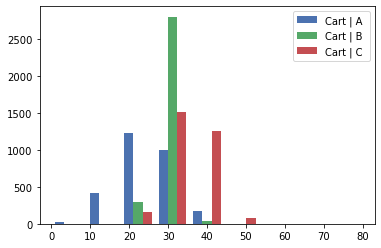

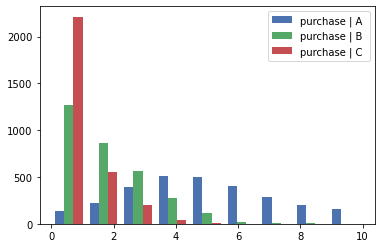

In [23]:

## Checkout page:

# Hyperparameters:
# Prob of assignment:
pa, pb, pc= .33, .34, .33

np.random.seed(31224)
p_vec = np.random.uniform(low=0, high = 1, size = n)

checkout_value = np.full(n, "C")
checkout_value[p_vec <=pa] = "A" ## 0- .33\]
checkout_value[(p_vec > pa) & (p_vec < pa+pb)] = "B" # \(.33 - .77\]

print(np.unique(checkout_value, return_counts=True))

## Integer of number of rows assigned to each checkout_page 
## This will be important for the conditional distributions later

page_type, counts = np.unique(checkout_value, return_counts=True)

n_a = counts[0] ## number with A
n_b = counts[1] ## number with B
n_c = counts[2] ## number with C

# Order value:
## Values | checkout condition:

mu, sda, sdb, sdc, = 30, 7, 2.5, 5 #break for readability
A_effect, B_effect, C_effect = -5, 0, 5

cart_value_a = rng.normal(mu + A_effect, sda, size = n_a )
cart_value_b = rng.normal(mu + B_effect, sdb, size = n_b )
cart_value_c = rng.normal(mu + C_effect, sdc, size = n_c )

## Truncate negative values. 
## I could import scipy stats for a true truncated normal,
## but don't need to be so precise 
## and can just round all negatives to 0
cart_value_a[cart_value_a < 0] = 0
cart_value_b[cart_value_b < 0] = 0
cart_value_c[cart_value_c < 0] = 0

## Show:

bins1 = np.linspace(0, 80, 10)

plt.hist([cart_value_a, cart_value_b, cart_value_c], 
         bins1, label=['Cart | A ', 'Cart | B', 'Cart | C'])

plt.legend(loc='upper right')
plt.show()

## Purchase:
# items purhcased:
lam_p, A_effect_p, B_effect_p, C_effect_p  = 2, 3, 0,  -1
purchase_a = rng.poisson(lam_p + A_effect_p, size = n_a)
purchase_b = rng.poisson(lam_p + B_effect_p, size= n_b)
purchase_c = rng.poisson(lam_p + C_effect_p, size = n_c)


bins2 = np.linspace(0, 10, 10)

plt.hist([purchase_a, purchase_b, purchase_c], 
        bins2, 
         label=['purchase | A ', 'purchase | B', 'purchase | C'])

plt.legend(loc='upper right')
plt.show()

## Quick check that none of the values have negatives:


Next I will do the time_on_page variable

This is an integer, with a minium value of 7.6 and a maximum value of 
83. 
We don't know the distribution of the data, nor the data generating process. So the first thing that I'll do is try to get a histogram, to give me a rough idea of what the distribution might look like. I get the nice surprise that the Data Camp terminal does allow me to call plots. From that I can observe that time_on_page looks like a relatively tight uniform distribution.

If I wanted to be comprensive, I could model the time_on_page variable as a function of checkout value, checkout page, and maybe browser. That would simulate a more realistic data generating process, such that there might be a narrative whereby customers remained on the page to shop for items and the different landing pages were more/less easy to use. However, since I note that the distribution of the data that I am trying to match is rough normal with relatively little spread, it looks like a straightforward ~N(43, 10.5)

As I mentioned above, eyeballing the distribution looks like a Normal with very little spread. That makes me suspect that I can approximate it without any particular dependencies. 

A more sophisticated model would vary time_on_page by checkout page variant, and potentially by number of items purchased and browser. That would represent a (slightly) more realistic data-generating process.

Given that I have the data that I am simulating, I can go in and check whether the mean varies according to some other value (in this case: experimental checkout page):

`print(checkout.groupby('checkout_page')['time_on_page'].mean())`

Doing so at Data Camp, I discover that the "A" condition produces a slightly higher mean in the time-to-checkout value: 44.67 versus 42.724 (B condition) and 42.224 (C). I can also use .groupby() to ask for the standard deviation according to the checkout page category. Doing so reveals that the standard deviation for group A is 11.6 and for groups B and C it is 9.705. 

I can build that into my model:


In [7]:
## Time on page:

## By looking at the data that I am matching,
## It seems to be Normally distributed, with a slight 
## effect of checkout page A:

mu_time, sda_time, sdb_time = 42.724, 11.6, 9.705 
A_etime, B_etime, C_etime = 2, 0, -0.5

time_on_page_a = rng.normal(mu_time + A_etime,
                            sda_time, size = n_a )
time_on_page_b = rng.normal(mu_time + B_etime,
                            sdb_time, size = n_b )
time_on_page_c = rng.normal(mu_time + C_etime, 
                            sdb_time, size = n_c )

Now that I have a seed dataframe, I'll go back into the tutorial and see if can get more information to refine and check my work. 

In doing so, I realized that I mis-understood one of the variables: "purchased" does not code for the *number* of items purchased. Instead, it appears to be a binary value for whether anything was purchased at all.

I like the "purchases" variable that we already made, so I'll keep it and add the "purchased" variable as ~Bin(9000, .85). (I'll also rename my original "purchase" variable to "items_purchased" to reduce future confusion.

This is almost what we want, although ideally we don't want the assignement data to be blocked when we attach the independent variables (user ID, gender, browser). Thus, first I use the `.sample()` method to shuffle the rows, then add the remaining variables.

In [10]:
## Zip all of the A, B, C, conditions:
va= pd.DataFrame({"purchase": purchase_a, 
                  "order_value": cart_value_a, 
                  "checkout_value": "A", 
                 "time_on_page": time_on_page_a})

vb= pd.DataFrame({"purchase": purchase_b, 
                  "order_value": cart_value_b,
                  "checkout_value": "B",
                  "time_on_page": time_on_page_b})

vc= pd.DataFrame({"purchase": purchase_c,
                  "order_value": cart_value_c, 
                  "checkout_value": "C",
                 "time_on_page": time_on_page_c})

checkout = pd.concat([va, vb, vc], 
                     ignore_index=True,
                     axis=0)

print(checkout.head())

   purchase  order_value checkout_value  time_on_page
0         5    19.986956              A     38.073215
1         7    19.777656              A     48.156596
2         2    25.508101              A     26.309232
3         4    30.871335              A     18.049385
4         7    30.974235              A     30.968870


In [11]:
checkout = checkout.sample(frac=1)

checkout["browser"] = pd.Series(browser)
checkout["user_id"] = pd.Series(user_id)
checkout["gender"]= pd.Series(gender)

print(checkout.describe())

          purchase  order_value  time_on_page      user_id       gender
count  9000.000000  9000.000000   9000.000000  9000.000000  9000.000000
mean      2.629000    30.099005     43.128276  4499.500000     0.507444
std       2.318323     6.510790     10.425844  2598.220545     0.499972
min       0.000000     2.613673      7.339559     0.000000     0.000000
25%       1.000000    26.907923     36.087407  2249.750000     0.000000
50%       2.000000    30.341479     42.977300  4499.500000     1.000000
75%       4.000000    33.949601     50.214656  6749.250000     1.000000
max      14.000000    53.791711     86.493732  8999.000000     1.000000


Now that I have a seed data frame, I'll go back into the tutorial and see if I can get more information to refine and check my work.

In doing so, I realized that I misunderstood one of the variables: "purchased" does not code for the *number* of items purchased. "Purchased" is actually a binary value for whether the shopper made a purchase.

I like the "items_purchased" variable that we already made, so I'll keep it and add the "purchased" variable as ~Bin(9000, .85). (I'll also rename my original "purchase" variable to "items_purchased" to reduce future confusion.

There is a small subtlety in that for the 15% of carts with no purchases, we also expect the order value and number of items to be 0. 

I'll use the previous generator to develop the baseline distribution.
Then, I'll go in and align the zeros.

In [14]:

n_purch, p_purch = 9000, .83

np.random.seed(31224)
purchased = rng.binomial(1, p_purch, size = n_purch)
print(purchased.mean())



0.8352222222222222


Insert the "purchased" vector into checkout, placing it near the order_value column:

In [15]:
checkout.insert(2, "purchased", purchased)

ValueError: cannot insert purchased, already exists

Small cleanup to the order_value feature: zero out rows where for which there was no purchase:

In [17]:

checkout.loc[checkout['purchased'] == 0, "order_value"] = 0
print(checkout.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 902 to 666
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   purchase        9000 non-null   int64  
 1   order_value     9000 non-null   float64
 2   purchased       9000 non-null   int64  
 3   checkout_value  9000 non-null   object 
 4   time_on_page    9000 non-null   float64
 5   browser         9000 non-null   object 
 6   user_id         9000 non-null   int64  
 7   gender          9000 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 632.8+ KB
None


Almost there, but when I look at the data in the tutorial, I also notice that the "order_value" column only has 7605 values, rather than the 9,000 values that I have.

To fix this, I'll randomly drop `9000-7605`  values, which represents the difference between my value and the Data Camp value:

In [18]:

random.seed(31224)
res = random.sample(range(1, n), (9000-7605))

checkout.loc[checkout['user_id'].isin(res), 'order_value'] = np.nan

print(checkout.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 902 to 666
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   purchase        9000 non-null   int64  
 1   order_value     7605 non-null   float64
 2   purchased       9000 non-null   int64  
 3   checkout_value  9000 non-null   object 
 4   time_on_page    9000 non-null   float64
 5   browser         9000 non-null   object 
 6   user_id         9000 non-null   int64  
 7   gender          9000 non-null   int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 632.8+ KB
None


Yay! Now (a day later....) I can save the synethetic data and get back to following along the tutorial!

In [20]:
# Save:
checkout.to_csv('../Data/checkout.csv', index=False) 